# Relatório parcial de transmissão digital
Transmissão Digital - Prof: Diniz

Aluno: Fernando Dias

Esse relatório tem como objetivo implementar e expandir alguns dos resultados obtidos pelo artigo "Channel Estimation and Performance Analysis of One-Bit Massive MIMO Systems". 

A proposta é avaliar qual o desempenho de um sistema MIMO massivo onde cada antena utiliza um conversor analógico digital de apenas um bit. O processo de estimação de canal se dá por um novo processo proposto pelo artigo que consiste na linearização dos efeitos de quantização em uma expressão estatisticamente equivalente.

Esse documento é do tipo `notebook` e o código é interativo e pode ser executado na plataforma `Colab` do google. O link para acesso ao documento é: 

## 0 - Preparação

O primeiro passo é preparar as principais funções a serem utilizadas ao longo desse relatório. As funções consistem em:
* Gerar matrizes de canal e matrizes de bits para transmissão
* Realizar modulação e demodulação QPSK
* Realizar a função de quantização

Começaremos o código importando as bibliotecas necessárias:

In [1]:
# Bibliotecas de terceiros
import numpy as np # Realiza cálculos matriciais eficientes
import scipy as sp # Contém as funções científicas mais comuns
import pandas as pd # Cria tabelas para visualização de dados
import matplotlib.pyplot as plt # Forma os gráficos 
import seaborn as sns # Biblioteca para formação rápida de gráficos
import cvxpy as cvx # Biblioteca para otimização convexa

### Geração do canal e dos bits

A primeira função é a `GerarCanal(M,K)`. Ela recebe as dimensões do canal e retorna a matriz de canal correspondente. Ela é definida na forma:

$$GerarCanal(M,K)\to H\in\mathbb{C}^{M\times K}\sim\mathcal{CN}(0,1)$$

Já a segunda é a `GerarBits(K,tamanho)`. Ela gera uma matriz de bits com $K$ colunas e $t$ bits para transmissão. É definida na forma:

$$GerarBits(K,\tau)\to B\in[0,1]^{K\times\tau}$$

In [2]:
def GerarCanal(M,K):
    """
    GerarCanal(M,K)
    Descrição:
        Gera a matriz de canal M*K. Onde M é o número de antenas 
        receptoras e K o número de antenas transmissoras.
    Recebe:
        - M: Número de antenas receptoras
        - K: Número de antenas transmissoras
    Retorna:
        - Matriz complexa M*K 
    """
    return np.matrix(np.random.normal(0,1,size=(M,K))+1j*np.random.normal(0,1,size=(M,K)))

def GerarBits(K,tamanhoMensagem):
    """
    GerarCanal(M,K)
    Descrição:
        Gera a matriz de canal M*K. Onde M é o número de antenas 
        receptoras e K o número de antenas transmissoras.
    Recebe:
        - M: Número de antenas receptoras
        - K: Número de antenas transmissoras
    Retorna:
        - Matriz complexa M*K 
    """
    return np.matrix(np.random.choice([0,1],size=(K,tamanhoMensagem)))

### (De)modulação e quantização

A próxima etapa consiste na definição do modulador e do demodulador QPSK. É trivial assumir que, devido a quantização na recepção, essa é a modulação escolhida. Assim, o demodulador QPSK já tem o processo de decisão que consiste em avaliar o sinal das partes reais e imaginárias do sistema.

In [3]:
def ModuladorQPSK(s):
    """
    ModuladorQPSK(s)
    Descrição:
        Recebe uma matriz de bits e retorna uma matriz de símbolos modulada em QPSK
    Parâmetros:
        - s: Matriz de bits
    Retorna:
        - Matriz de símbolos QPSK de energia unitária
    """
    #if tuple(np.unique(s)) != (0,1):
    #    raise Exception("Deve receber matriz de bits (0 ou 1)")
        
    return (np.where(s==0,-1,1)[:,::2]+1j*np.where(s==0,-1,1)[:,1::2])/np.sqrt(2)

def DemoduladorQPSK(s):
    """
    DemoduladorQPSK(s)
    Descrição:
        Recebe uma matriz de símbolos complexos e retorna a matriz de bits correspondente
    Parâmetros:
        - s: Matriz de símbolos
    Retorna: 
        - Matriz de bits
    """
    return np.stack([
        np.where(np.real(s)>0,1,0), # Faz a decisão com base no sinal do número complexo
        np.where(np.imag(s)>0,1,0)
    ]).swapaxes(0,1).reshape(s.shape[0],-1,order='F')

Ao invés de explicar passo a passo como as funções acima funcionam, abaixo está uma prova de conceito que prova que os moduladores funcionam.

In [4]:
# Define as dimensões da matriz de bits
K = 1000
T = 10000

# Matriz de bits aleatória
s = np.random.choice([0,1],size=(K,T))

# Faz a modulação
s_mod = ModuladorQPSK(s)

# Faz a demodulação
s_demod = DemoduladorQPSK(s_mod)

# Retorna true apenas se todos os elementos de s_demod 
# sao iguais aos de s
np.equal(s_demod,s).all()

True

O próximo passo é a definição do quantizador. A única diferença entre o quantizador e o demodulador QPSK é que o quantizador mantém os símbolos complexos e não converte para bits. Aplicar o demodulador no resultado do quantizador tem o mesmo efeito de aplicar o demodulador diretamente.

In [5]:
def Quantizador(data):
    """
    Quantizador(signal)
    Descrição:
        Realiza a quantização do sinal recebido. 
        A quantização é equivalente à modulação QPSK.
    Parâmetros:
        - signal: O sinal (complexo) a ser quantizado. 
    Retorna:
        - Sinal quantizado. 
    """
    return ( np.sign(np.real(data)) + 1j * np.sign(np.imag(data)) ) / np.sqrt(2)

### Cálculo dos receptores

Os receptores considerados no trabalho são dois: O _Maximum Ratio Combining_ (MRC) e o _Zero Forcing_ (ZF). Serão definidas duas funções que retornam os receptores com base na matriz de canal estimado.

Os receptores são definidos de forma idêntica as equações (39) e (40) do artigo.

In [6]:
def ReceptorZF(H_est,signal=None):
    """
    ReceptorZF(H_est,signal)
    Calcula o receptor ZF com base no `H_est` e o aplica no `signal`.
    Parâmetros:
        - H_est: Estimativa do canal para aplicar o receptor
        - signal (default=None): Sinal na qual processar o receptor
    Retorna:
        - Se tiver sinal, 
            - Retorna o sinal depois de aplicado o receptor
        - Se não tiver sinal,
            - Retorna a matriz do receptor
    """
    # Detecta erros
    if type(H_est) != np.matrix:
        raise Exception("H_est tem que ser do tipo np.matrix")
    
    # Calculo do receptor
    receptor = np.linalg.inv(H_est.H@H_est)@H_est.H
    
    if not type(signal) == type(None):
    # Aplicacao do receptor ao resultado
        return receptor@signal
    
    return receptor

def ReceptorMRC(H_est,signal=None):
    """
    ReceptorMRC(H_est,signal)
    Descrição:
        Calcula o receptor MRC com base no `H_est` e o aplica no `signal`, se dado. Caso
    Parâmetros:
        - H_est: Estimativa do canal para aplicar o receptor
        - signal (default=None): Sinal na qual processar o receptor
    Retorna:
        - Se tiver sinal, 
            - Retorna o sinal depois de aplicado o receptor
        - Se não tiver sinal,
            - Retorna a matriz do receptor
    """
    # Detecção de erro
    if type(H_est) != np.matrix:
        raise Exception("H_est deve ser do tipo np.matrix")
    
    # Calculo do receptor
    receptor = H_est.H
    
    if not type(signal) == type(None):
        # Aplicacao do receptor ao resultado
        return receptor@signal
    
    return receptor

### Transmissão MIMO

Finalmente, será definido o processo de transmissão MIMO. Para isso será definida uma função que simplesmente aplica a fórmula de transmissão:
$$\mathbf{y}=\sqrt{\rho}H\mathbf{s}+\mathbf{n}$$
Para cada execução dessa função, um novo valor de ruído AWGN é calculado.

Para converter o SNR para o $\sqrt{\rho}$ do artigo, fez-se a conversão do valor em dB para linear pela relação 

$$\text{SNR}^{[\text{linear}]}=10^{\frac{\text{SNR}^{[\text{dB}]}}{10}}$$

já que a relação é de amplitude entre os termos. Finalmente, a potência é dividida entre os $K$ usuários. Assim $$\rho_d=\frac{\text{SNR}^{[\text{linear}]}}{K}$$

Essa dinâmica está representada na função `dB2linear` abaixo.

In [7]:
def CalcularRho(SNR,K):
    """
    CalcularRhoD(SNR,K)
    Descrição:
        Calcula o valor de rho_d a partir do valor SNR da transmissão e divide entre os usuários.
    Parâmetros: 
        - SNR: Relação sinal ruído
        - K: Número de usuários
    """
    return (10**(SNR/10))/K

In [8]:
def TransmissaoMIMO(H,s,SNR=15):
    """
    TransmissaoMIMO(H,s,power=1,N0=1)
    Descrição:
        Realiza uma transmissão MIMO pelo canal H especificado 
        e adiciona um ruído branco e gaussiano no resultado.
    Parâmetros:
        - H: Canal de dimensão M*K
        - s: Sinal com dimensões K*(message length)
        - SNR: Signal to Noise Ratio em dB (default 15)
    Retorna:
        - y: Sinal recebido de dimensões M*(message length)
    """
    # Cálculo do ruído a ser aplicado
    noise = np.random.normal(0,1,size=(H.shape[0],s.shape[1]))

    # Divide a potência entre todos os usuários
    rho = CalcularRho(SNR,H.shape[1])
    
    # Retorna resultado da transmissão, divide o ruído pelo SNR
    return np.sqrt(rho)*np.matmul(H,s) + noise

Para demonstrar o que foi obtido até então. Será simulado um processo de comunicação MIMO para um caso simples, com $M=16$ antenas e $K=4$ usuários para diferentes níveis de SNR e será calculado o BER.

## Prova de conceito de transmissão MIMO

In [9]:
quantizar = True
quantidadeBits = 20
SNR = 10 
M = 4
K = 2

# Repete o experimento 1000 vezes
BERList = []
for i in range(1000):
    # Gera o canal
    H = GerarCanal(M,K)
    W = np.linalg.inv(H.H@H)@H.H # Maximum ratio combining

    # Gera os bits e símbolos
    b = GerarBits(K,quantidadeBits)
    s = ModuladorQPSK(b)

    # Faz a transmissão 
    y = TransmissaoMIMO(H,s,SNR=SNR)

    # Faz a quantização
    r = Quantizador(y) if quantizar else y
    s_est = W@r

    # Demodula o sinal para bits
    b_est = DemoduladorQPSK(s_est)

    # Calcula o BER
    BER = np.sum(np.abs(b_est-b))/(b_est.shape[0]*b_est.shape[1])
    
    BERList.append(BER)

# Retorna os resultados
#print("Canal:\n",H)
#print("Receptor:\n",W)
#print("bits:\n",b)
#print("Transmissão:\n",y)
#print("Quantizado:\n",r)
#print("bits estimados:\n",b_est)
print("BER: ",sum(BERList)/len(BERList))

BER:  0.06684999999999985


## Experimento 1: BER de uma transmissão MIMO sem quantização

# Experimento 2: Transmissão MIMO com variação do número de antenas receptoras

Vamos fazer um novo experimento que, para o mesmo SNR baixo, verifica a variação no desempenho de recepção dos dois receptores com o aumento no número de antenas receptoras.

Vemos que o desempenho de recepção melhora com o número de antenas receptoras. Outro resultado já esperado segundo a teoria do MIMO.

## 1 - Estimação de canal

A estimação de canal consiste em obter $\hat H$ a partir do canal $H$. Para isso, serão utilizados os seguintes estimadores:

* `EstimarCanalMS`: Faz a estimação por mínimos quadradoas do canal supondo que o canal é linear.
    * Será calculado `MS` e `MS-Quant` para as estimações feitas em uma transmissão sem quantização e com quantização, respectivamente.
* `EstimarCanalAQN`: Faz a estimação seguindo o modelo de Bussgang só que sempre supondo que $\tau=K$.
* `EstimarCanalBussgang`: É o estimador proposto na equação (15).

O processo de estimação consiste em fazer uma transmissão de valores piloto e observar a matriz de símbolos recebidos. Para os estimadores de Bussgang e o AQN, preferiu-se por utilizar a função de quantização diretamente ao invés de utilizar os modelos para ser justo e testar a proposta dos estimadores, que devem ter desempenhos melhores devido ao fundamento probabilístico na definição de suas equações.

A matriz $A_p$, definida na equação (6) e calculada na (7), possui uma simplificação quando a sequência piloto escolhida é a matriz de DFT truncada, demonstrada na equação (11). Será escolhida dessa forma as sequências piloto para todos os estimadores.

São definidas duas funções auxiliares para os estimadores: As funções `Vect` e `AutoCorr` definidas abaixo:

In [10]:
def Vect(Matriz):
    """
    Vect(Matriz)
    Descrição:
        Vetoriza a `Matriz`
    """
    return Matriz.ravel(order='F')

# Exemplo
a = np.array([
    [1,4,7],
    [2,5,8],
    [3,6,9]
])
Vect(a)

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [11]:
def AutoCorr(vector):
    """
    AutoCorr(vector)
    Descrição: 
        Realiza a autocorrelação de um vetor com apenas uma realização.
        Apenas para a definição do Bussgang
        
    """
    
    return np.outer(vector,vector)

**Importante**: Ainda está em processo de investigação a definição acima, devido a não-claridade do que o artigo se refere. Isso será explicado em mais detalhes na seção de estimação com o estimador de Bussgang.

### Estimador MS

O princípio do estimador MS é realizar a operação descrita na equação (4) diretamente. O passo de quantização define entre usar o resultado de (4) ou (5) no cálculo. Se a matriz $\bar\Phi$ for quadrada, é resolvido $A\mathbf{x}=\mathbf{b}$ diretamente, caso contrário, vira um problema de mínimos quadrados.

In [12]:
def EstimarCanalMS(H_real,tamanhoPiloto=None,SNR=20,quant=True):
    # Obtenção dos parâmetros importantes
    K = H_real.shape[1]
    M = H_real.shape[0]
    
    # Define tamanho do piloto caso não definido
    if not tamanhoPiloto:
        tamanhoPiloto = K

    # Calculo da potência linear
    Rho_p = CalcularRho(SNR,K)

    # Calcula matriz de pilotos
    pilotos = np.fft.fft(np.eye(max(tamanhoPiloto,K)))
    Phi = pilotos[0:tamanhoPiloto,0:K] 

    # Faz a transmissão para receber os pilotos
    Y_rec = TransmissaoMIMO(H_real,Phi.T,SNR=SNR)
    if quant:
        Y_rec = Quantizador(Y_rec)

    # Calcula a equação de estimação do canal
    Phi_bar = np.kron(Phi,Rho_p*np.eye(M))
    H_est = np.linalg.lstsq(Phi_bar,Vect(Y_rec).T,rcond=None)[0]
    
    return H_est.reshape(H_real.shape,order="F")

### Estimador AQN

O estimador AQN aproveita a simplificação que o artigo indica e aplica a função (16) diretamente. 

Essa aproximação é dada pelo artigo _" In fact, (14) can be reduced to the estimator derived in \[28\] if $\tau = K$ is assumed"_.

In [13]:
def EstimarCanalAQN(H_real,SNR=20):
    """
    EstimarCanalBussgang(H_real)
    Descrição:
        Estima o canal e retorna um canal estimado
    Parametros:
        - H_real: Canal real
        - tamanhoPiloto (default=None): Quantidade de símbolos piloto 
        para transmissão. Se vazio, considera igual ao número de antenas
        definido por H_real.
        - SNR (default=20): SNR do treinamento, em dB
    Return:
        - H_est: Canal estimado
    """
    # Obtenção dos parâmetros importantes
    K = H_real.shape[1]
    M = H_real.shape[0]
    tamanhoPiloto = K
    
    # Cria matriz piloto segundo especificações
    pilotos = np.fft.fft(np.eye(max(tamanhoPiloto,K)))
    Phi = pilotos[0:tamanhoPiloto,0:K] 
    
    # Calcula matriz Ap da decomposicao
    rho_d = CalcularRho(SNR,K)
    Ap = np.sqrt((2/np.pi)*(1/(K*rho_d+1)))*np.eye(M*tamanhoPiloto)
    
    # Calcula a relação de equação
    Phi_bar = np.kron(Phi,rho_d*np.eye(M))
    Phi_tilde = np.matrix(np.matmul(Ap,Phi_bar))
    
    # Faz a transmissão no canal e quantiza o resultado
    Y_rec = TransmissaoMIMO(H_real,Phi.T,SNR=SNR)
    R_rec = Quantizador(Y_rec)
    R_rec = Vect(R_rec)
    
    # Calcula o estimador
    H_est = np.matmul(Phi_tilde.H,R_rec)
    
    return H_est.reshape(H_real.shape,order='F')

### Estimador proposto

O estimador proposto pode ser calculado diretamente da equação (14).

Para o cálculo desse estimador, é necessário descobrir qual a matriz de autocorrelação de $\mathbf{r}_p$, ela é obtida com a fórmula (13), que exige descobrir a autocorrelação de $\mathbf{y}_p$. A demonstração do cálculo dessa matriz está abaixo:

Temos a função de estimação de sinal 

$$y_p=\bar\Phi\mathbf{h}+\mathbf{n}_p$$

Aplicamos a fórmula para a matriz de autocovariância:

$$\mathbf{C}_{\mathbf{y}_p}=E[\mathbf{y}_p\mathbf{y}_p^H]=E[(\bar\Phi\mathbf{h}+\mathbf{n}_p)(\bar\Phi\mathbf{h}+\mathbf{n}_p)^H]=
E[\bar\Phi\mathbf{h}\mathbf{h}^H\bar\Phi^H+\bar\Phi\mathbf{h}\mathbf{n}_p^H+\mathbf{n}_p\mathbf{h}^H\bar\Phi^H+\mathbf{n}_p\mathbf{n}_p^H]=\bar\Phi\mathbf{C}_{\mathbf{h}}\bar\Phi^H+2\bar\Phi\mathbf{C}_{\mathbf{h},\mathbf{n}_p}+\mathbf{C}_{\mathbf{n}_p}$$

Como $2\bar\Phi\mathbf{C}_{\mathbf{h},\mathbf{n}_p}=0$, temos que finalmente:

$$\mathbf{C}_{\mathbf{y}_p}=\bar\Phi\mathbf{C}_{\mathbf{h}}\bar\Phi^H+\mathbf{C}_{\mathbf{n}_p}$$

Já o artigo da referência \[40\] define uma estimativa da correlação de $\mathbf{y}_p$ com base no próprio valor recebido. A estimativa é calculada como:

$$\hat C_{y_p} = E[y_py_p^H]+I_M$$

In [46]:
def EstimarCanalBussgang(H_real,tamanhoPiloto=None,SNR=20,estimar=False):
    """
    EstimarCanalBussgang(H_real)
    Descrição:
    Estima o canal e retorna um canal estimado
    Parametros:
    - H_real: Canal real
    - tamanhoPiloto (default=None): Quantidade de símbolos piloto 
    para transmissão. Se vazio, considera igual ao número de antenas
    definido por H_real.
    - SNR (default=20): SNR do treinamento, em dB
    - estimativaCorrelacao (default=False): Se verdadeiro, calcula a 
    estimativa baseado no valor recebido de y_p. Se falso, calcula com base na formula acima.
    Return:
    - H_est: Canal estimado
    """
    
    # Recupera informações de número de antenas da matriz de H real
    K = H_real.shape[1]
    M = H_real.shape[0]
    
    # Valor padrão para tamanho piloto
    if not tamanhoPiloto:
        tamanhoPiloto = K
    
    rho_d = CalcularRho(SNR,K)
    
    # Cria matriz piloto segundo especificações
    pilotos = np.fft.fft(np.eye(max(tamanhoPiloto,K)))
    Phi = pilotos[0:tamanhoPiloto,0:K] 
    
    Ap = np.sqrt((2/np.pi)*(1/(K*rho_d+1)))*np.eye(M*tamanhoPiloto)
    
    Phi_bar = np.kron(Phi,rho_d*np.eye(M))
    
    Phi_tilde = np.matrix(np.matmul(Ap,Phi_bar))

    Y_rec = TransmissaoMIMO(H_real,Phi.T,SNR=SNR)
    R_rec = Quantizador(Y_rec)   

    if estimar:
        Corr_y = (Vect(Y_rec)@Vect(Y_rec).H)/tamanhoPiloto + np.eye(M*tamanhoPiloto)
    else:
        Corr_y = Phi_bar@np.eye(M*K)@np.matrix(Phi_bar).H+np.eye(M*tamanhoPiloto)
    
    diagY = np.diag(np.sqrt(1/np.diag(Corr_y)))
    
    Corr_R = (2/np.pi)*(np.arcsin(diagY@np.real(Corr_y)@diagY) + 1j*(np.arcsin(diagY@np.imag(Corr_y)@diagY)))
    
    H_est = np.matmul(Phi_tilde.H,np.linalg.inv(Corr_R))
    H_est = np.matmul(H_est,Vect(R_rec).T)
    
    return H_est.reshape(H_real.shape,order='F')

Para avaliar o erro de estimativa, usa-se a métrica de erro médio quadrático.

In [47]:
# Cálculo para determinar o erro médio quadrático normalizado
def CalcularNMSE(H_est,H_real):
    res = float((np.abs(Vect((H_est-H_real))@Vect((H_est-H_real)).H))[0,0])
    NMSE = res / (H_real.shape[0]*H_real.shape[1])
    return 10*np.log10(NMSE)

### Prova de conceito de estimação

In [49]:
repeticoesExpr = 1000
M = 16
K = 4
Estimador = EstimarCanalMS
params = {"SNR":-20,'tamanhoPiloto':20}#,"quant":False}

res = []
for i in range(repeticoesExpr):
    H = GerarCanal(M,K)
    H_est = Estimador(H,**params)
    res.append(CalcularNMSE(H_est,H))

print("Média do NMSE:",sum(res)/len(res))

Média do NMSE: 41.70025275975165


Finalmente, vamos testar a capacidade dos estimadores até o momento:

O gráfico acima mostra os mesmos resultados que a figura 2 do artigo com a adição de duas novas curvas: A curva para o estimador de mínimos quadrados (MS) e a curva para o estimador de mínimos quadrados quando se quantiza o resultado da transmissão (MS-Quant). Podemos observar que esses estimadores possuem um desempenho pior que um dos estimadores comparados para o caso de SNR baixo. Surpreendentemente, estimar via MS em um caso de baixo SNR dá um resultado melhor quando a transmissão é quantizada do que quando é linar, o que acaba assim que o SNR fica maior que 5.

Para repetir o gráfico da figura 2, fazemos o gráfico abaixo:

A comparação não pode ser feita justamente porque ainda não temos o resultado do estimador proposto.

Uma vez conseguindo realizar o estimador, pode-se repetir os resultados das figuras 2 e 3.

## Otimização da eficiência espectral

Cálculo da equação 48

In [17]:
def CalcularEficienciaEspectralAnaliticaMRC(M,K,tau,SNR,T):
    rho_p = CalcularRho(SNR,K)
    rho_d = rho_p
    # Variáveis auxiliares
    alpha_p_squared = (2*np.pi)*(1/(K*rho_p+1))
    alpha_d_squared = (2*np.pi)*(1/(K*rho_d+1))
    sigma2 = (alpha_p_squared*tau*rho_p)/(alpha_p_squared*tau*rho_p+alpha_p_squared+1-(2/np.pi))
    # Capacidade do usuário
    R = np.log2(1+rho_d*(alpha_d_squared)*M*sigma2)
    
    # Eficiência espectral
    return ((T-tau)/T)*K*R

def CalcularEficienciaEspectralAnaliticaZF(rho_p,rho_d,M,K,tau,SNR,T):
    rho_p = CalcularRho(SNR,K)
    rho_d = rho_p
    
    # Variáveis auxiliares
    alpha_p_squared = (2*np.pi)*(1/(K*rho_p+1))
    alpha_d_squared = (2*np.pi)*(1/(K*rho_d+1))
    sigma2 = (alpha_p_squared*tau*rho_p)/(alpha_p_squared*tau*rho_p+alpha_p_squared+1-(2/np.pi))
    # Capacidade do usuário
    eta = 1-sigma2
    R = np.log2(1+((rho_d*(alpha_d_squared)*(M-K)*sigma2)/(rho_d*alpha_d_squared*K*eta+alpha_d_squared+1-(2/np.pi))))

    # Eficiência espectral
    return ((T-tau)/T)*K*R

In [30]:
# Experimento via Monte-Carlo
def CalcularEficienciaEspectralMonteCarlo(M,K,tau,SNR,T,epsilon=None,repeticoes=1000,Receptor=None):
    S_res = np.zeros(repeticoes)
    
    if Receptor is None:
        raise Exception("Dê-me receptor")
        
    for reps in range(repeticoes):
        
        # Gera canal aleatório
        H = GerarCanal(M,K) 
        # Calcula valores
        rho_d = CalcularRho(SNR,K)
        # Estimação e erro de canal
        H_est = EstimarCanalBussgang(H,tamanhoPiloto=tau,SNR=SNR)
        erroCanal = H_est - H
        # Receptor
        WT = Receptor(H_est)
        # Matriz de quantização
        Ad = np.sqrt(2/(np.pi*(K*rho_d+1)))*np.eye(M)    
        # Sinal
        sign = rho_d*np.power(np.abs(np.diag(WT@Ad@H_est)[:,np.newaxis]),2)
        # Ruído
        noise = rho_d*np.power(np.abs(np.sum(WT@Ad@H_est-np.diag(np.diag(WT@Ad@H_est)),axis=1)),2) +\
                rho_d*np.power(np.abs(np.sum(WT@Ad@erroCanal,axis=1)),2) +\
                np.power(np.linalg.norm(WT@Ad,axis=1)[:,np.newaxis],2) +\
                np.real(np.diag((WT)@((1-2/np.pi)*np.eye(M))@np.transpose(np.conj(WT))))[:,np.newaxis]
        #import pdb;pdb.set_trace()
        # Capacidade
        R = (1 + sign/noise)
        # Eficiência espectral
        S = (T-tau)*np.sum(R)/T
        S_res[reps] = S
        
    return pd.Series(S_res).describe()

for i in range(-20,0,2):
    print(CalcularEficienciaEspectralMonteCarlo(8,4,2,i,200,Receptor=ReceptorMRC,repeticoes=10)['mean'])


3.960000388784228
3.9600015211514843
3.960005851695629
3.9600218364793016
3.960081065063501
3.960300011243047
3.96097247322352
3.96282926879755
3.9700009917626202
3.984481629032108


In [43]:
H = np.array([
    [0.7+0.6j,-0.6+0.7j],
    [-0.7-0.7j,0.7-0.5j]
])

EstimarCanalBussgang(H,SNR=-20) 

matrix([[ 5.61389618e-03-8.29304670e-21j,
         -8.29304670e-21+5.61389618e-03j],
        [ 5.61389618e-03-5.61389618e-03j,
         -8.29304670e-21+8.29304670e-21j]])

In [19]:
%%time 

from itertools import product
from tqdm.notebook import tqdm

def FazerFigura3():
    K = 8
    tau = K
    T = 200
    metodos = {
        ("Analítica","MRC"):(CalcularEficienciaEspectralAnaliticaMRC,{}),
        ("Analítica","ZF"):(CalcularEficienciaEspectralAnaliticaZF,{})
    }
    
    res = pd.DataFrame()
    for metodo in metodos.keys():
        for M in [32,64,128]:
            for SNR in range(-20,0,1):
                # Busca funções e parâmetros
                CalcularEficienciaEspectral = metodos[metodo][0]
                params = metodos[metodo][1]
                # Calcula a eficiência espectral
                S = CalcularEficienciaEspectralAnaliticaMRC(M,K,tau,SNR,T)
                # Encontra o epsilon que gerou o valor máximo
                res = pd.concat([res,
                    pd.DataFrame({"S":S},index=pd.MultiIndex.from_tuples([tuple([*metodo]+[M,SNR])],names=['Modo','Receptor','M','SNR']))
                ])
    
    metodos = [("MRC",ReceptorMRC),("ZF",ReceptorZF)]
    for M,SNR,receptor in tqdm(product([32,64,128],list(range(-20,0,4)),metodos)):
        print(f"M={M},SNR={SNR},receptor={receptor}")
        S_res = CalcularEficienciaEspectralMonteCarlo(M,K,tau,SNR,T,Receptor=receptor[1],repeticoes=5)
        res = pd.concat([res,
            pd.DataFrame({"S":S_res['mean']},index=pd.MultiIndex.from_tuples([("Monte-Carlo",receptor[0],M,SNR)],names=['Modo','Receptor','M','SNR']))
        ])
    return res
res = FazerFigura3()
res

0it [00:00, ?it/s]

M=32,SNR=-20,receptor=('MRC', <function ReceptorMRC at 0x7f0ae550f5e0>)
M=32,SNR=-20,receptor=('ZF', <function ReceptorZF at 0x7f0ae550f3a0>)
M=32,SNR=-16,receptor=('MRC', <function ReceptorMRC at 0x7f0ae550f5e0>)
M=32,SNR=-16,receptor=('ZF', <function ReceptorZF at 0x7f0ae550f3a0>)
M=32,SNR=-12,receptor=('MRC', <function ReceptorMRC at 0x7f0ae550f5e0>)
M=32,SNR=-12,receptor=('ZF', <function ReceptorZF at 0x7f0ae550f3a0>)
M=32,SNR=-8,receptor=('MRC', <function ReceptorMRC at 0x7f0ae550f5e0>)
M=32,SNR=-8,receptor=('ZF', <function ReceptorZF at 0x7f0ae550f3a0>)
M=32,SNR=-4,receptor=('MRC', <function ReceptorMRC at 0x7f0ae550f5e0>)
M=32,SNR=-4,receptor=('ZF', <function ReceptorZF at 0x7f0ae550f3a0>)
M=64,SNR=-20,receptor=('MRC', <function ReceptorMRC at 0x7f0ae550f5e0>)
M=64,SNR=-20,receptor=('ZF', <function ReceptorZF at 0x7f0ae550f3a0>)
M=64,SNR=-16,receptor=('MRC', <function ReceptorMRC at 0x7f0ae550f5e0>)
M=64,SNR=-16,receptor=('ZF', <function ReceptorZF at 0x7f0ae550f3a0>)
M=64,SNR=-

S
Modo        Receptor M   SNR          
Analítica   MRC      32  -20  0.025776
                         -19  0.040616
                         -18  0.063892
                         -17  0.100284
                         -16  0.156939
...                                ...
Monte-Carlo ZF       128 -12  7.680901
            MRC      128 -8   7.685429
            ZF       128 -8   7.687835
            MRC      128 -4   7.743733
            ZF       128 -4   7.736397

[150 rows x 1 columns]

In [20]:
res.loc['Monte-Carlo','ZF',64]

/tmp/ipykernel_10603/3412587423.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  res.loc['Monte-Carlo','ZF',64]


,S
SNR,
-20,7.680003
-16,7.680038
-12,7.680484
-8,7.684969
-4,7.719975


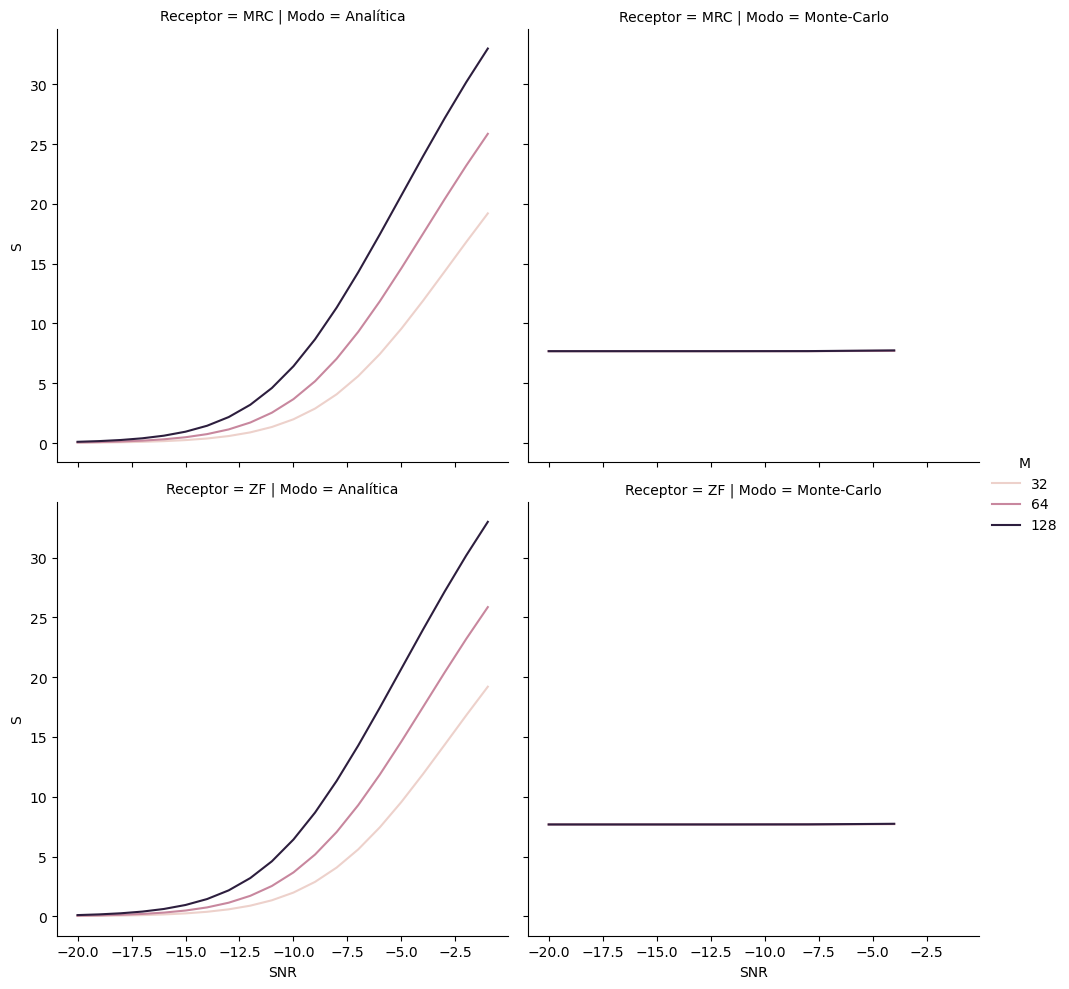

In [21]:
sns.relplot(data=res.reset_index(),x='SNR',y='S',hue='M',col='Modo',row='Receptor',kind='line')